# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [ ]:
import os, sys, random
import tarfile
from pathlib import Path
from time import gmtime, strftime

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image

if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [ ]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2025-04-12 20:09:00--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2025-04-12 20:09:00--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.1s    

2025-04-12 20:09:01 (54.1 MB/s) - ‘images_evaluation.zip’ saved [6

In [ ]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [ ]:
import tempfile
import shutil

def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to directory with files
    Returns:
      datax (np.array): array of path names of images
      datay (np.array): array of labels
    """
    datax = []
    datay = []
    # ----- Временная директория ----- #
    temp_dir = tempfile.mkdtemp()


    for char_dir in sorted(os.listdir(alphabet_directory_path)):
        char_path = os.path.join(alphabet_directory_path, char_dir)
        if not os.path.isdir(char_path):
            continue

        for img_file in sorted(os.listdir(char_path)):
            if not img_file.endswith('.png'):
                continue

            img_path = os.path.join(char_path, img_file)
            img = Image.open(img_path)


            original_path = os.path.join(temp_dir, f"{char_dir}_{img_file}_0.png")
            img.save(original_path)
            datax.append(original_path)
            datay.append(char_dir + '_0')

            # ----- ЦИКЛ С ПОВОРОТАМИ ----- #
            for rot in [1, 2, 3]:
                rotated_img = img.rotate(rot * 90)
                rotated_path = os.path.join(temp_dir, f"{char_dir}_{img_file}_{rot}.png")
                rotated_img.save(rotated_path)
                datax.append(rotated_path)
                datay.append(char_dir + f'_{rot}')

    return np.array(datax), np.array(datay)


In [ ]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None

    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [ ]:
#trainx, trainy = read_images('/kaggle/input/training-dataset-images-hw-3/images_background')
trainx, trainy = read_images('/kaggle/working/images_background')

In [ ]:
#testx, testy = read_images('/kaggle/input/images-hw-3/images_evaluation')
testx, testy = read_images('/kaggle/working/images_evaluation')

In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120,), (77120,), (52720,), (52720,))

## Create samples

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append([cv2.resize(cv2.imread(fname), (28, 28))
                                  for fname in sample_cls])

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [ ]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

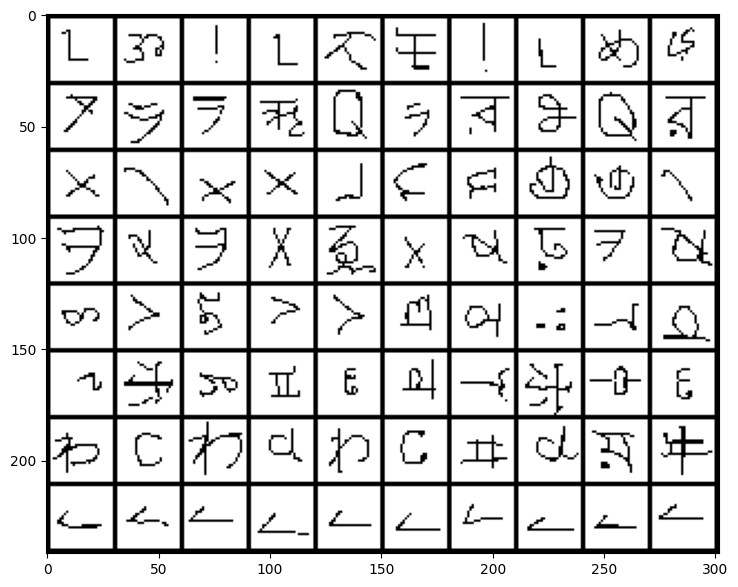

In [ ]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [ ]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [ ]:
# pass your code
class Layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Layer, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        return self.layer(x)


class ImageEncoder(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=64, out_dim=64):
        super(ImageEncoder, self).__init__()
        self.net = nn.Sequential(
            Layer(in_dim, hidden_dim),
            Layer(hidden_dim, hidden_dim),
            Layer(hidden_dim, hidden_dim),
            Layer(hidden_dim, out_dim),
            nn.Flatten())

    def forward(self, x):
        # x shape: [batch_size, n_classes, C, H, W] или [n_way, n_support+n_query, C, H, W]
        original_shape = x.shape
        x = x.reshape(-1, *x.shape[-3:])  # [batch_size*n_classes, C, H, W]
        x = self.net(x)  # [batch_size*n_classes, D]
        return x.reshape(original_shape[0], original_shape[1], -1)  # [batch_size, n_classes, D]

In [ ]:
ie = ImageEncoder()
ie_out = ie(sample_example['images'])
ie_out.shape

torch.Size([8, 10, 64])

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [ ]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Args:
            sample (dict): {
                'images': tensor of shape (n_way, n_support+n_query, C, H, W),
                'n_way': int,
                'n_support': int,
                'n_query': int
            }
        Returns:
            tuple: (loss, {
                'loss': float,
                'acc': float,
                'y_hat': tensor
            })
        """
        sample_images = sample['images'].cuda()  # [n_way, n_support+n_query, C, H, W]
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        embeddings = self.encoder(sample_images)  # [n_way*(n_support+n_query), D]

        support = embeddings[:, :n_support, :]  # [n_way, n_support, D]
        queries = embeddings[:, n_support:, :]  # [n_way, n_query, D]

        prototypes = torch.mean(support, dim=1)  # [n_way, D]

        distances = torch.cdist(
            queries.reshape(-1, queries.size(-1)),  # [n_way*n_query, D]
            prototypes,  # [n_way, D]
            p=2
        )  # [n_way*n_query, n_way]

        logits = -distances
        labels = torch.arange(n_way, device=prototypes.device)
        labels = labels.repeat_interleave(n_query)  # [n_way*n_query]

        loss = F.cross_entropy(logits, labels)
        y_hat = torch.argmax(logits, dim=1)
        acc = (y_hat == labels).float().mean()

        return loss, {'loss': loss.item(), 'acc': acc.item(), 'y_hat': y_hat}

In [ ]:
def load_protonet_conv(x_dim=(3, 28, 28), hid_dim=64, z_dim=64):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = ImageEncoder(in_dim=x_dim[0], hidden_dim=hid_dim, out_dim=z_dim)
    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [ ]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, experiment):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """

    experiment["parameters/n_way"] = n_way
    experiment["parameters/n_support"] = n_support
    experiment["parameters/n_query"] = n_query
    experiment["parameters/max_epoch"] = max_epoch
    experiment["parameters/epoch_size"] = epoch_size
    experiment["parameters/optimizer"] = type(optimizer).__name__
    experiment["parameters/learning_rate"] = optimizer.param_groups[0]['lr']

    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']

            experiment[f"epoch_{epoch}_episode_loss"].log(output['loss'])
            experiment[f"epoch_{epoch}_episode_acc"].log(output['acc'])

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size

        experiment["train/epoch_loss"].log(epoch_loss)
        experiment["train/epoch_acc"].log(epoch_acc)
        experiment["train/learning_rate"].log(optimizer.param_groups[0]['lr'])

        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()

    experiment["final/train_loss"] = epoch_loss
    experiment["final/train_acc"] = epoch_acc

In [ ]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 220
n_support = 10
n_query = 10

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [ ]:
!pip install neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 10.7 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=bcbe5e327a38087e2b48e881084779e8d658cd5802560b3190c1a460f4baa626
  Stored in directory: /root/.cache/pip/wheels/cf/d7/1c/1d707a21e0a0323bdbfbb2f6de125ae6bb70d62aa2838df321
Successfully built bravado-core


In [ ]:
import neptune

In [ ]:
run = neptune.init_run(
    project="eduard-andreev/Images-homework-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiN2QxMjE1NS01YjYwLTQ0NWMtYThjYy1jOWFjYmU0ODUwNjEifQ==",
)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/eduard-andreev/Images-homework-3/e/IM-17


In [ ]:
print("Unique classes in dataset:", len(np.unique(train_y)))
print("Requested n_way:", n_way)

Unique classes in dataset: 220
Requested n_way: 220


In [ ]:
%%time

#
train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, experiment=run)

Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 3.0948 Acc: 0.3506


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 2.4375 Acc: 0.4597


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 2.2549 Acc: 0.4920


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 2.1726 Acc: 0.5069


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 2.1350 Acc: 0.5137
CPU times: user 2h 51min 16s, sys: 18min 43s, total: 3h 9min 59s
Wall time: 3h 4min 57s


In [ ]:
#torch.save(model.state_dict(), "trained_model_v1.pt")
model.load_state_dict(torch.load('trained_model_v1.pt'))

/tmp/ipykernel_31/184997536.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model_v1.pt'))


<All keys matched successfully>

## Test

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [ ]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 1.9913 Acc: 0.3189


## Test on specific example

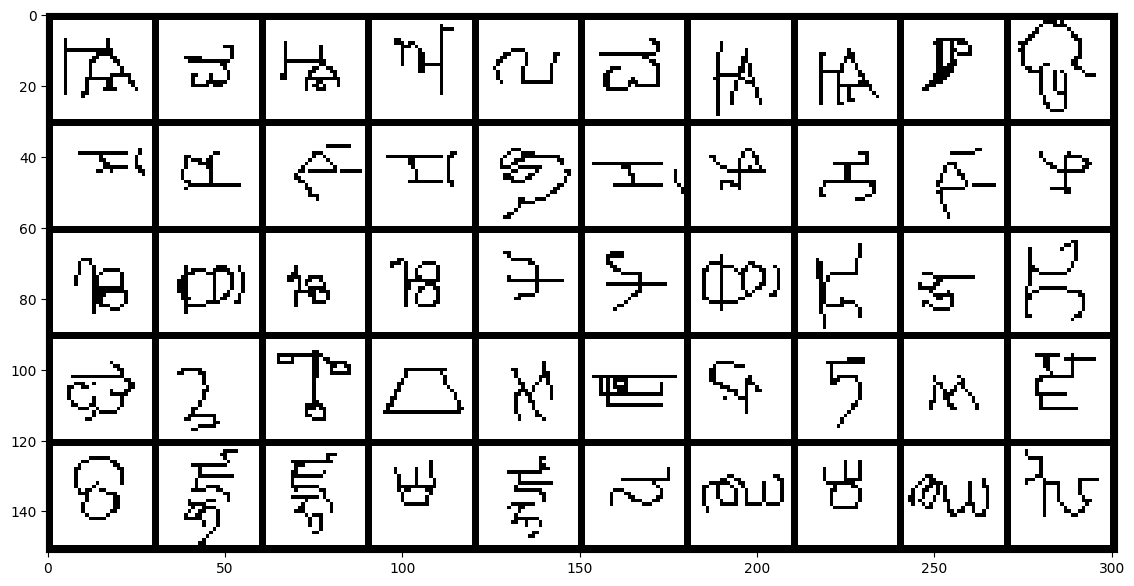

In [ ]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def visualize_prediction_episode(model, test_x, test_y, n_way, n_support, n_query, class_names=None):
    """
    Визуализирует предсказания ProtoNet на одном тестовом эпизоде.
    """
    model.eval()
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    with torch.no_grad():
        loss, output = model.set_forward_loss(sample)

    images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    support_images = images[:, :n_support]
    query_images = images[:, n_support:]

    y_true = torch.arange(n_way).repeat_interleave(n_query)
    y_pred = output['y_hat'].cpu()

    inv_transform = transforms.ToPILImage()

    fig, axs = plt.subplots(n_way, n_query + n_support, figsize=(2 * (n_query + n_support), 2 * n_way))

    for i in range(n_way):
        for j in range(n_support):
            img = inv_transform(support_images[i, j].cpu() / 255.)
            axs[i, j].imshow(img)
            axs[i, j].set_title(f"Support\nClass {i}" if class_names is None else f"Support\n{class_names[i]}")
            axs[i, j].axis("off")

        for j in range(n_query):
            idx = i * n_query + j
            pred = y_pred[idx].item()
            true = y_true[idx].item()
            color = "green" if pred == true else "red"
            img = inv_transform(query_images[i, j].cpu() / 255.)
            axs[i, j + n_support].imshow(img)
            title = f"Pred {pred}" if class_names is None else f"Pred {class_names[pred]}"
            axs[i, j + n_support].set_title(title, color=color)
            axs[i, j + n_support].axis("off")

    plt.tight_layout()
    plt.show()


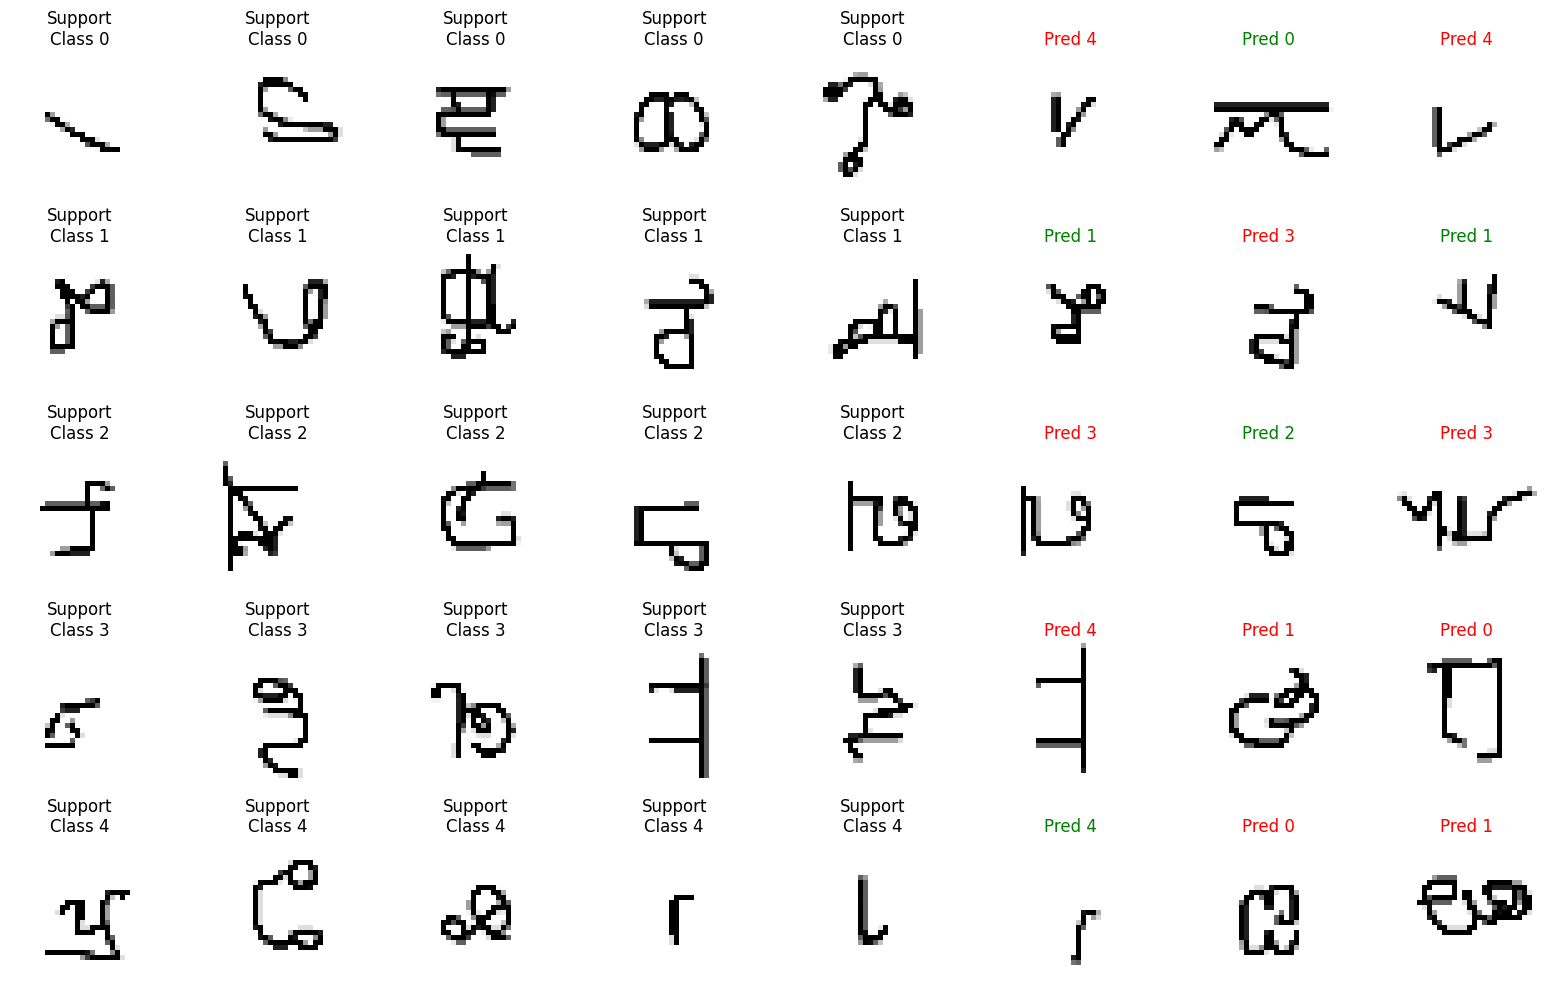

In [ ]:
visualize_prediction_episode(model, test_x, test_y, n_way=5, n_support=5, n_query=3)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [ ]:
def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):

    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data", channels_last=True)

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

Dataset not found. Downloading...
(40000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (10000,)


In [ ]:
# вспомогательная функция
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

In [ ]:
# порядок функций аугментации
transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90()
])

In [ ]:
# выберем случайное изображение
idx = np.random.choice(tuple(range(len(X_train))), 1)[0]

sample_image = (X_train[idx] * 255).astype(np.uint8)

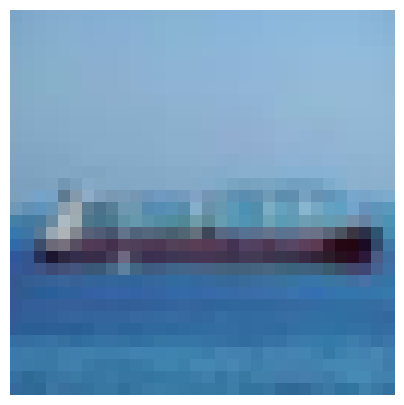

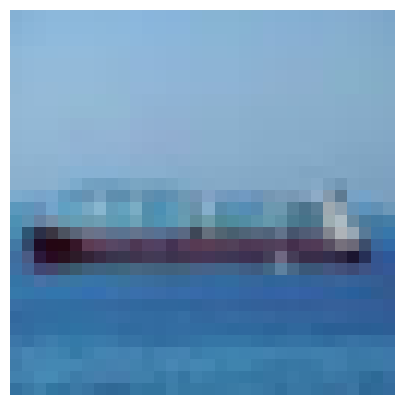

In [ ]:
augmented_image = transform(image=sample_image)['image']
visualize(augmented_image)
visualize(sample_image)

In [ ]:
transform = A.Compose([
        A.RandomRotate90(),
        A.HorizontalFlip(),
        A.Transpose(),
        A.OneOf([
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


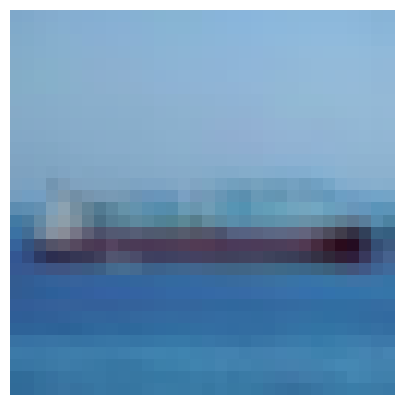

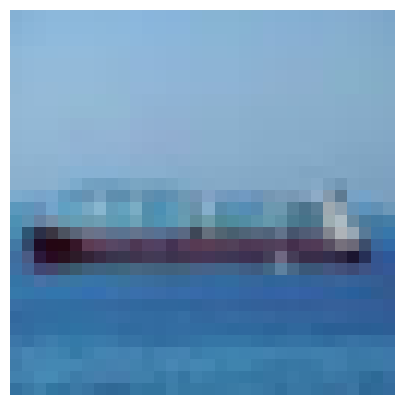

In [ ]:
augmented_image = transform(image=sample_image)['image']
visualize(augmented_image)
visualize(sample_image)

In [ ]:
class CLDataset(Dataset):
    def __init__(self, x_data, y_data, transform_augment=None):
        self.x_data = x_data
        self.y_data = y_data

        assert transform_augment is not None, 'set transform_augment'
        # TODO: pass your code
        self.transform_augment = transform_augment

    def __len__(self):
        # TODO: pass your code
        return len(self.x_data)

    def __getitem__(self, item):
        image = self.x_data[item]
        image = (image * 255).astype(np.uint8)
        label = self.y_data[item]

        # TODO: pass your code
        x1 = self.transform_augment(image=image)['image']
        x2 = self.transform_augment(image=image)['image']

        image = torch.tensor(image).permute(2, 0, 1)

        return x1, x2, label, image

In [ ]:
MEAN = list(np.mean(X_train, axis=(0, 1, 2), keepdims=True).squeeze())
STD = list(np.std(X_train, axis=(0, 1, 2), keepdims=True).squeeze())

In [ ]:
train_transform = A.Compose([
    A.OneOf([
        A.ColorJitter(),
        A.ToGray(),
#         A.GaussNoise(),
    ]),
#     A.OneOf([
#         A.Cutout(num_holes=1, max_h_size=10, max_w_size=10),
#         A.RandomResizedCrop(32, 32),
#         A.GaussianBlur(),
#     ]),
    A.HorizontalFlip(),
#     A.RandomRotate90(),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

valid_transform = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
])

In [ ]:
train_dataset = CLDataset(X_train, y_train, transform_augment=train_transform)
valid_dataset = CLDataset(X_val, y_val, transform_augment=valid_transform)

In [ ]:
batch_size = 32
n_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=n_workers)

val_loader = torch.utils.data.DataLoader(valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=n_workers)

In [ ]:
x1, x2, _, _ = next(iter(train_loader))
print(x1.shape, x2.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 3, 32, 32])


In [ ]:
def plot_batch(x, STD, MEAN):
    plt.figure(figsize=[12, 10])
    plt.axis('off')

    grid = torchvision.utils.make_grid(x, 4, )
    grid = grid.numpy().transpose((1, 2, 0))
    grid = grid * STD + MEAN
    plt.imshow(grid)

    plt.tight_layout()

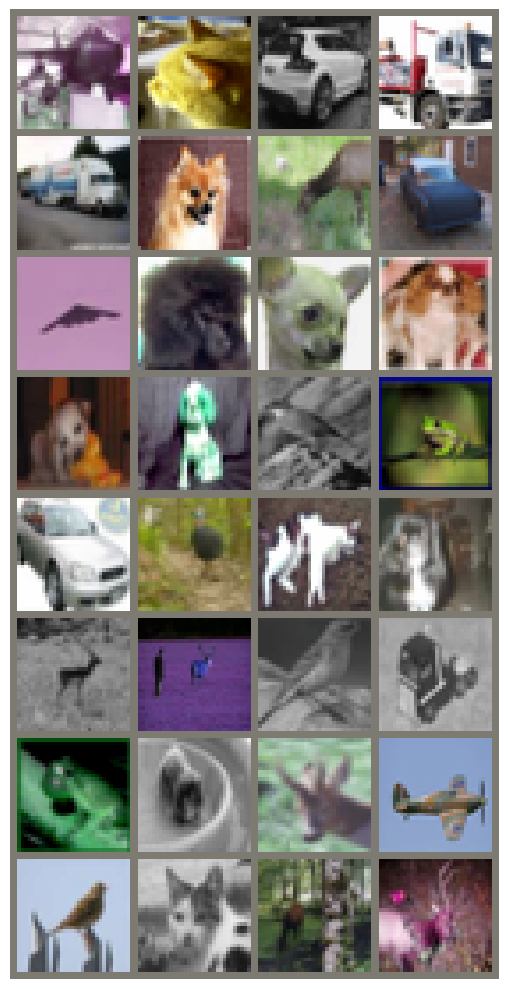

In [ ]:
plot_batch(x1, STD, MEAN)

In [ ]:
def get_cropped_data_idxs(data, crop_coef: float = 1.0):
    crop_coef = np.clip(crop_coef, 0, 1)

    init_data_size = len(data)
    final_data_size = int(init_data_size * crop_coef)

    random_idxs = np.random.choice(tuple(range(init_data_size)), final_data_size, replace=False)
    return random_idxs

def load_datasets(X_train, y_train, X_val, y_val, crop_coef=0.2):
    train_idxs = get_cropped_data_idxs(X_train, crop_coef=crop_coef)
    train_data = X_train[train_idxs]
    train_labels = y_train[train_idxs]

    valid_idxs = get_cropped_data_idxs(X_val, crop_coef=crop_coef)
    valid_data = X_val[valid_idxs]
    valid_labels = y_val[valid_idxs]

    train_dataset = CLDataset(train_data, train_labels, transform_augment=train_transform)
    valid_dataset = CLDataset(valid_data, valid_labels, transform_augment=valid_transform)

    return train_dataset, valid_dataset

In [ ]:
train_dataset, valid_dataset = load_datasets(X_train, y_train, X_val, y_val, crop_coef=1.4)
print('Train size:', len(train_dataset), 'Valid size:', len(valid_dataset))

Train size: 40000 Valid size: 10000


In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          drop_last=True
                         )

In [ ]:
x1, x2, _, ori = next(iter(train_loader))
x1.shape

torch.Size([32, 3, 32, 32])

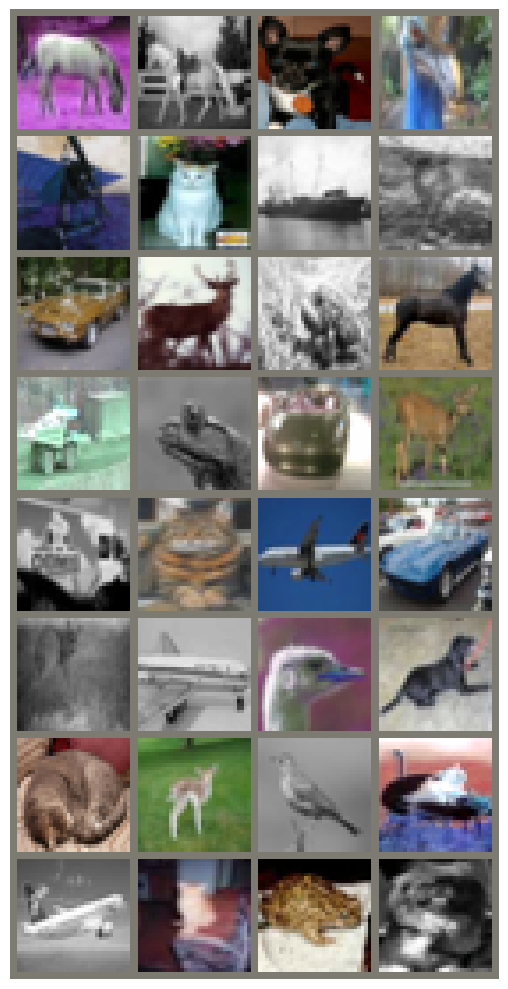

In [ ]:
plot_batch(x1, STD, MEAN)

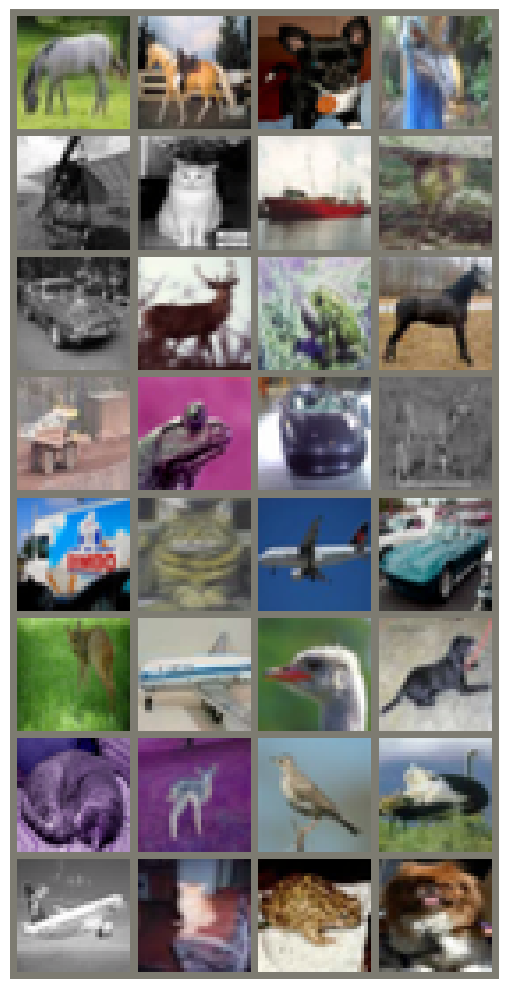

In [ ]:
plot_batch(x2, STD, MEAN)

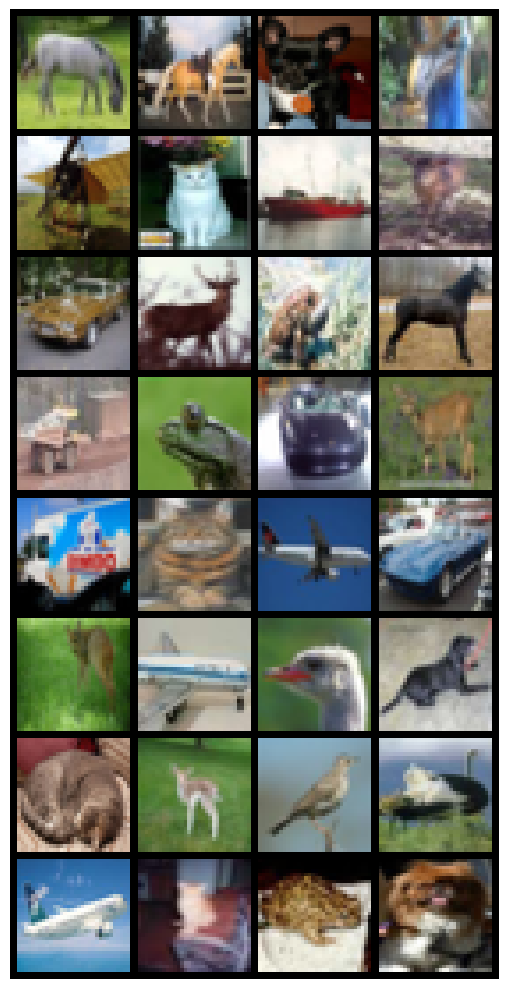

In [ ]:
plot_batch(ori, 1, 0)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [ ]:
class LinearLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 use_bias = True,
                 use_bn = False,
                 **kwargs):
        super().__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias
        self.use_bn = use_bn

        self.linear = nn.Linear(self.in_features,
                                self.out_features,
                                bias = self.use_bias and not self.use_bn)
        if self.use_bn:
             self.bn = nn.BatchNorm1d(self.out_features)

    def forward(self,x):
        x = self.linear(x)
        if self.use_bn:
            x = self.bn(x)
        return x

In [ ]:
def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class ProjectionHead(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 out_features,
                 head_type = 'nonlinear',
                 **kwargs):
        super().__init__(**kwargs)

        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.head_type = head_type

        if self.head_type == 'linear':
            self.layers = LinearLayer(self.in_features, self.out_features, use_bias=False, use_bn=True)
        elif self.head_type == 'nonlinear':
            self.layers = nn.Sequential(
                LinearLayer(self.in_features, self.hidden_features, use_bias=True, use_bn=True),
                nn.ReLU(),
                LinearLayer(self.hidden_features, self.out_features, use_bias=False, use_bn=True))

    def forward(self,x):
        x = l2_norm(x)
        x = self.layers(x)
        return x


class PreModel(nn.Module):
    def __init__(self):
        super().__init__()

        # pretrained model
        model = torchvision.models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*tuple(model.children())[:-1])

        emb_size = tuple(model.children())[-1].in_features

        for p in self.encoder.parameters():
            p.requires_grad = False

        self.projector = ProjectionHead(emb_size, 2048, 10)

    def forward(self,x):
        out = self.encoder(x)

        xp = self.projector(torch.squeeze(out))

        return xp

In [ ]:
device = 'cuda'
model = PreModel()
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


In [ ]:
x = np.random.random((32,3,224,224))

In [ ]:
out = model(torch.tensor(x, device=device, dtype=torch.float32))

In [ ]:
out.shape

torch.Size([32, 10])

In [ ]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()

        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

        self.tot_neg = 0

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0

        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        # SIMCLR
        labels = torch.from_numpy(np.array([0] * N)).reshape(-1).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [ ]:
x1 = torch.tensor(np.random.random((4, 128)))
x2 = torch.tensor(np.random.random((4, 128)))

loss = SimCLR_Loss(batch_size=4, temperature=0.2).to(device)
loss(x1, x2)

tensor(1.9290, dtype=torch.float64)

In [ ]:
def plot_features(model, dataloader, device='cpu'):
    feats = []
    labels = []
    model.eval()

    with torch.no_grad():
        pbar = tqdm(dataloader, total=len(dataloader), desc='collect feats')
        for x1, x2, label, _ in pbar:
            x1 = x1.to(device)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats.append(out)
            labels.append(label.cpu().data.numpy())

    feats = np.concatenate(feats)
    labels = np.concatenate(labels)

    print('Train TSNE ...')
    tsne = TSNE(n_components=2, perplexity=50, verbose=0, n_jobs=4)
    x_feats = tsne.fit_transform(feats)

    print('Plot labels ...')
    num_classes = len(np.unique(labels))
    fig = plt.figure(figsize=(6.4 * 2, 4.8 * 1))

    for i in range(num_classes):
        label_idxs = np.argwhere(labels == i)
        plt.scatter(x_feats[label_idxs, 1],x_feats[label_idxs, 0])

    plt.legend([str(i) for i in range(num_classes)])
    plt.axis('off')
    plt.margins(0)
    plt.tight_layout()
    plt.close()
    return fig

In [ ]:
model = PreModel()
fig = plot_features(model, val_loader)

collect feats:   0%|          | 0/313 [00:00<?, ?it/s]

Train TSNE ...
Plot labels ...


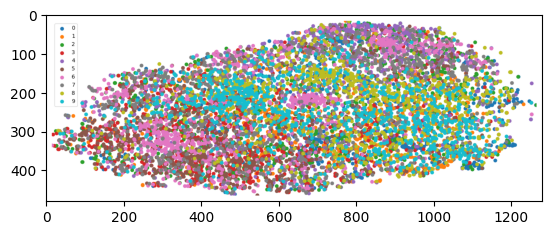

In [ ]:
fig.canvas.draw()
image_from_plot = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (4,))

image_from_plot = image_from_plot[..., :3]

plt.imshow(image_from_plot)

In [ ]:
class BaseTrainProcess:
    def __init__(self, hyp, experiment=None):
        start_time = strftime("%Y-%m-%d %H-%M-%S", gmtime())

        self.best_loss = 1e100
        self.best_acc = 0.0
        self.current_epoch = -1
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.experiment = experiment  # Neptune experiment object

        self.hyp = hyp

        self.lr_scheduler: Optional[torch.optim.lr_scheduler] = None
        self.model: Optional[torch.nn.modules] = None
        self.optimizer: Optional[torch.optim] = None
        self.criterion: Optional[torch.nn.modules] = None

        self.train_loader: Optional[Dataloader] = None
        self.valid_loader: Optional[Dataloader] = None

        # Log hyperparameters to Neptune
        if self.experiment is not None:
            self._log_hyperparameters()

        self.init_params()

    def _log_hyperparameters(self):
        """Log all hyperparameters to Neptune"""
        self.experiment["parameters"] = {
            "batch_size": self.hyp['batch_size'],
            "epochs": self.hyp['epochs'],
            "lr": self.hyp['lr'],
            "weight_decay": self.hyp['weight_decay'],
            "temperature": self.hyp['temperature'],
            "n_workers": self.hyp['n_workers']
        }
        self.experiment["parameters/optimizer"] = "AdamW"
        self.experiment["parameters/scheduler"] = "CosineAnnealingWarmRestarts"

    def init_params(self):
        self._init_data()
        self._init_model()

    def _init_data(self):
        train_dataset, valid_dataset = load_datasets(X_train, y_train, X_val, y_val, crop_coef=1.4)
        print('Train size:', len(train_dataset), 'Valid size:', len(valid_dataset))

        if self.experiment is not None:
            self.experiment["data/train_size"] = len(train_dataset)
            self.experiment["data/valid_size"] = len(valid_dataset)

        self.train_loader = DataLoader(train_dataset,
                                     batch_size=self.hyp['batch_size'],
                                     shuffle=True,
                                     num_workers=self.hyp['n_workers'],
                                     pin_memory=True,
                                     drop_last=True)

        self.valid_loader = DataLoader(valid_dataset,
                                     batch_size=self.hyp['batch_size'],
                                     shuffle=True,
                                     num_workers=self.hyp['n_workers'],
                                     pin_memory=True,
                                     drop_last=True)

    def _init_model(self):
        self.model = PreModel()
        self.model.to(self.device)

        if self.experiment is not None:
            self.experiment["model/architecture"] = str(self.model)

        model_params = [params for params in self.model.parameters() if params.requires_grad]
        self.optimizer = torch.optim.AdamW(model_params, lr=self.hyp['lr'], weight_decay=self.hyp['weight_decay'])

        self.warmupscheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lambda epoch: (epoch + 1) / 10.0)
        self.mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            500,
            eta_min=0.05,
            last_epoch=-1,
        )

        self.criterion = SimCLR_Loss(batch_size=self.hyp['batch_size'],
                                   temperature=self.hyp['temperature']).to(self.device)

    def save_checkpoint(self, loss_valid, path):
        if loss_valid[0] <= self.best_loss:
            self.best_loss = loss_valid[0]
            self.save_model(path)

    def save_model(self, path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.mainscheduler.state_dict()
        }, path)

    def train_step(self):
        self.model.train()
        self.optimizer.zero_grad()
        self.model.zero_grad()

        cum_loss = 0.0
        cum_acc = 0.0
        proc_loss = 0.0

        pbar = tqdm(enumerate(self.train_loader), total=len(self.train_loader),
                    desc=f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (xi, xj, _, _) in pbar:
            xi, xj = xi.to(self.device), xj.to(self.device)

            with torch.set_grad_enabled(True):
                zi = self.model(xi)
                zj = self.model(xj)
                loss = self.criterion(zi, zj)

                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                self.model.zero_grad()

            cur_loss = loss.detach().cpu().item()
            cum_loss += cur_loss
            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)

            sim = torch.cosine_similarity(zi, zj)
            acc = (sim > 0.5).float().mean().item()
            cum_acc += acc

            if self.experiment is not None:
                self.experiment["train/batch_loss"].log(cur_loss)
                self.experiment["train/batch_acc"].log(acc)

            s = f'Train {self.current_epoch}/{self.hyp["epochs"] - 1}, Loss: {proc_loss:4.3f}, Acc: {acc:4.3f}'
            pbar.set_description(s)

        epoch_loss = cum_loss / len(self.train_loader)
        epoch_acc = cum_acc / len(self.train_loader)

        if self.experiment is not None:
            self.experiment["train/epoch_loss"].log(epoch_loss)
            self.experiment["train/epoch_acc"].log(epoch_acc)

        return [epoch_loss]


    def valid_step(self):
        self.model.eval()

        cum_loss = 0.0
        cum_acc = 0.0
        proc_loss = 0.0

        pbar = tqdm(enumerate(self.valid_loader), total=len(self.valid_loader),
                    desc=f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}')
        for idx, (xi, xj, _, _) in pbar:
            xi, xj = xi.to(self.device), xj.to(self.device)

            with torch.set_grad_enabled(False):
                zi = self.model(xi)
                zj = self.model(xj)
                loss = self.criterion(zi, zj)

            cur_loss = loss.detach().cpu().item()
            cum_loss += cur_loss
            proc_loss = (proc_loss * idx + cur_loss) / (idx + 1)

            # Similarity accuracy
            sim = torch.cosine_similarity(zi, zj)
            acc = (sim > 0.5).float().mean().item()
            cum_acc += acc

            if self.experiment is not None:
                self.experiment["valid/batch_loss"].log(cur_loss)
                self.experiment["valid/batch_acc"].log(acc)

            s = f'Valid {self.current_epoch}/{self.hyp["epochs"] - 1}, Loss: {proc_loss:4.3f}, Acc: {acc:4.3f}'
            pbar.set_description(s)

        epoch_loss = cum_loss / len(self.valid_loader)
        epoch_acc = cum_acc / len(self.valid_loader)

        if self.experiment is not None:
            self.experiment["valid/epoch_loss"].log(epoch_loss)
            self.experiment["valid/epoch_acc"].log(epoch_acc)

        return [epoch_loss]

    def run(self):
        best_w_path = 'best.pt'
        last_w_path = 'last.pt'

        train_losses = []
        valid_losses = []

        for epoch in range(self.hyp['epochs']):
            self.current_epoch = epoch

            loss_train = self.train_step()
            train_losses.append(loss_train)

            if epoch < 10:
                self.warmupscheduler.step()
            else:
                self.mainscheduler.step()

            lr = self.optimizer.param_groups[0]["lr"]
            if self.experiment is not None:
                self.experiment["train/learning_rate"].log(lr)

            loss_valid = self.valid_step()
            valid_losses.append(loss_valid)

            self.save_checkpoint(loss_valid, best_w_path)

            if (epoch + 1) % 10 == 0 or epoch == self.hyp['epochs'] - 1:
                fig = plot_features(self.model, self.valid_loader, device=self.device)
                fig.canvas.draw()
                image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                if self.experiment is not None:
                    self.experiment["visualizations/tsne"].log(
                        neptune.types.File.as_image(image_from_plot)
                    )

        self.save_model(last_w_path)
        torch.cuda.empty_cache()

        # Log final metrics
        if self.experiment is not None:
            self.experiment["final/train_loss"] = train_losses[-1][0]
            self.experiment["final/valid_loss"] = valid_losses[-1][0]
            self.experiment["artifacts/best_model"].upload(best_w_path)
            self.experiment["artifacts/last_model"].upload(last_w_path)

        return train_losses, valid_losses

In [ ]:
hyps = {'batch_size': 128, 'lr': 0.2, 'lrf': 0.02, 'epochs': 3, 'weight_decay': 0.0004, 'n_workers': 0, 'temperature': 0.5, 'seed': 42}

In [ ]:
run = neptune.init_run(
    project="eduard-andreev/Images-homework-3",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiN2QxMjE1NS01YjYwLTQ0NWMtYThjYy1jOWFjYmU0ODUwNjEifQ==",
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/eduard-andreev/Images-homework-3/e/IM-20


In [ ]:
set_seed(hyps['seed'])

trainer = BaseTrainProcess(hyps, experiment=run)
#trainer.device = 'cpu'
trainer.init_params()

Train size: 40000 Valid size: 10000
Train size: 40000 Valid size: 10000


In [ ]:
#train_losses, valid_losses = trainer.run()

In [ ]:
fig = plot_features(model, val_loader, device='cpu')
fig.canvas.draw()
image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

collect feats:   0%|          | 0/313 [00:00<?, ?it/s]

Train TSNE ...
Plot labels ...


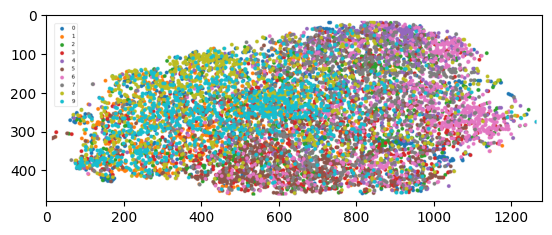

In [ ]:
plt.imshow(image_from_plot)

In [ ]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

In [ ]:
trained_model = model

In [ ]:
class ProtoNet2(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet2, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Args:
            sample (dict): {
                'images': tensor of shape (n_way, n_support+n_query, C, H, W),
                'n_way': int,
                'n_support': int,
                'n_query': int
            }
        Returns:
            tuple: (loss, {
                'loss': float,
                'acc': float,
                'y_hat': tensor
            })
        """
        sample_images = sample['images'].cuda()  # [n_way, n_support+n_query, C, H, W]
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x = sample_images.reshape(-1, *sample_images.shape[-3:])  # [n_way*(n_support+n_query), C, H, W]
        embeddings = self.encoder(x)  # [n_way*(n_support+n_query), D]
        embeddings = embeddings.reshape(n_way, n_support + n_query, -1)  # [n_way, n_support+n_query, D]

        support = embeddings[:, :n_support, :]  # [n_way, n_support, D]
        queries = embeddings[:, n_support:, :]  # [n_way, n_query, D]

        prototypes = torch.mean(support, dim=1)  # [n_way, D]

        distances = torch.cdist(
            queries.reshape(-1, queries.size(-1)),  # [n_way*n_query, D]
            prototypes,  # [n_way, D]
            p=2
        )  # [n_way*n_query, n_way]

        logits = -distances
        labels = torch.arange(n_way, device=prototypes.device)
        labels = labels.repeat_interleave(n_query)  # [n_way*n_query]

        loss = F.cross_entropy(logits, labels)
        y_hat = torch.argmax(logits, dim=1)
        acc = (y_hat == labels).float().mean()

        return loss, {'loss': loss.item(), 'acc': acc.item(), 'y_hat': y_hat}

In [ ]:
trained_model

PreModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True